# Exploratory Data Analysis (EDA) - Dipstick Detection Project

Project untuk deteksi dipstick dalam gambar menggunakan YOLO.
- **Dataset**: dipstickGambar (images dengan dipstick), noneGambar (images tanpa dipstick), dipstickAnotasi (annotations YOLO format)
- **Classes**: 
  - 0: Oil Dipstick
  - 1: Blur Dipstick
- **Goal**: Prepare data untuk training dengan split 70% train, 20% val, 10% test

In [1]:
# Import required libraries
import os
import glob
import shutil
import random
import yaml
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from collections import Counter, defaultdict

# Set style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

# Set random seed for reproducibility
random.seed(42)
np.random.seed(42)

## 1. Data Overview - File Counts

In [19]:
# Define paths
base_path = Path(r'D:\Project\2026 Magang Telkom\Dipstick-detection\data\_cvat-annot')
dipstick_img_path = base_path / 'images' 
#none_img_path = base_path / 'noneGambar'
annotation_path = base_path / 'annotatoions.xml'

# Count files
dipstick_images = list(dipstick_img_path.glob('*.png'))
#none_images = list(none_img_path.glob('*.png'))
#annotations = list(annotation_path.glob('*.txt'))

print("="*60)
print("DATA OVERVIEW")
print("="*60)
print(f"Total Dipstick Images: {len(dipstick_images)}")
#print(f"Total None Images (negative samples): {len(none_images)}")
#print(f"Total Annotations: {len(annotations)}")
#print(f"Total Dataset: {len(dipstick_images)}")
print("="*60)

DATA OVERVIEW
Total Dipstick Images: 1902


## 2. Annotation Analysis

In [5]:
# Analyze annotations
class_names = {0: "Oil Dipstick", 1: "Blur Dipstick"}
class_counts = {0: 0, 1: 0}
objects_per_image = []
empty_annotations = 0
annotation_data = []

for ann_file in annotations:
    with open(ann_file, 'r') as f:
        lines = f.readlines()
    
    if len(lines) == 0:
        empty_annotations += 1
        objects_per_image.append(0)
    else:
        num_objects = 0
        for line in lines:
            if line.strip():
                parts = line.strip().split()
                if len(parts) > 0:
                    class_id = int(parts[0])
                    class_counts[class_id] = class_counts.get(class_id, 0) + 1
                    num_objects += 1
                    annotation_data.append({
                        'file': ann_file.stem,
                        'class_id': class_id,
                        'class_name': class_names.get(class_id, 'Unknown')
                    })
        objects_per_image.append(num_objects)

print("\n" + "="*60)
print("ANNOTATION STATISTICS")
print("="*60)
print(f"Images with annotations: {len(annotations) - empty_annotations}")
print(f"Empty annotations (no objects): {empty_annotations}")
print(f"\nClass Distribution:")
for class_id, count in sorted(class_counts.items()):
    class_name = class_names.get(class_id, 'Unknown')
    print(f"  Class {class_id} ({class_name}): {count} objects")
print(f"\nObjects per image:")
print(f"  Mean: {np.mean(objects_per_image):.2f}")
print(f"  Median: {np.median(objects_per_image):.2f}")
print(f"  Min: {np.min(objects_per_image)}")
print(f"  Max: {np.max(objects_per_image)}")
print("="*60)

TypeError: 'WindowsPath' object is not iterable

## 3. Visualizations

In [ ]:
# Create visualizations
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. Dataset Distribution
ax1 = axes[0, 0]
dataset_counts = {
    'Dipstick Images': len(dipstick_images),
    'None Images': len(none_images)
}
colors = ['#2ecc71', '#e74c3c']
ax1.bar(dataset_counts.keys(), dataset_counts.values(), color=colors, alpha=0.7, edgecolor='black')
ax1.set_ylabel('Count', fontsize=12, fontweight='bold')
ax1.set_title('Dataset Distribution', fontsize=14, fontweight='bold')
ax1.grid(axis='y', alpha=0.3)
for i, (k, v) in enumerate(dataset_counts.items()):
    ax1.text(i, v + 10, str(v), ha='center', va='bottom', fontsize=11, fontweight='bold')

# 2. Class Distribution
ax2 = axes[0, 1]
if class_counts:
    classes = [class_names.get(k, f'Class {k}') for k in sorted(class_counts.keys())]
    counts = [class_counts[k] for k in sorted(class_counts.keys())]
    colors_class = ['#3498db', '#9b59b6']
    ax2.bar(classes, counts, color=colors_class, alpha=0.7, edgecolor='black')
    ax2.set_ylabel('Number of Objects', fontsize=12, fontweight='bold')
    ax2.set_title('Class Distribution', fontsize=14, fontweight='bold')
    ax2.grid(axis='y', alpha=0.3)
    ax2.tick_params(axis='x', rotation=15)
    for i, v in enumerate(counts):
        ax2.text(i, v + 5, str(v), ha='center', va='bottom', fontsize=11, fontweight='bold')

# 3. Objects per Image Distribution
ax3 = axes[1, 0]
ax3.hist(objects_per_image, bins=range(0, max(objects_per_image)+2), 
         color='#e67e22', alpha=0.7, edgecolor='black')
ax3.set_xlabel('Number of Objects', fontsize=12, fontweight='bold')
ax3.set_ylabel('Number of Images', fontsize=12, fontweight='bold')
ax3.set_title('Objects per Image Distribution', fontsize=14, fontweight='bold')
ax3.grid(axis='y', alpha=0.3)

# 4. Annotation Status
ax4 = axes[1, 1]
annotation_status = {
    'With Objects': len(annotations) - empty_annotations,
    'Empty (No Objects)': empty_annotations
}
colors_pie = ['#27ae60', '#c0392b']
wedges, texts, autotexts = ax4.pie(annotation_status.values(), labels=annotation_status.keys(), 
                                     autopct='%1.1f%%', colors=colors_pie, startangle=90,
                                     textprops={'fontsize': 11, 'fontweight': 'bold'})
ax4.set_title('Annotation Status', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

## 4. Data Preparation for YOLO Training

Split data menjadi:
- **Train**: 70%
- **Validation**: 20%
- **Test**: 10%

Data akan diorganisir dalam format YOLO standard dengan struktur folder yang sesuai.

In [5]:
def prepare_yolo_dataset(dipstick_img_path, none_img_path, annotation_path, 
                         output_path, train_ratio=0.7, val_ratio=0.2, test_ratio=0.1):
    """
    Prepare dataset for YOLO training dengan split train/val/test
    
    Parameters:
    - dipstick_img_path: Path ke folder dipstick images
    - none_img_path: Path ke folder none images  
    - annotation_path: Path ke folder annotations
    - output_path: Path output untuk dataset yang sudah diorganisir
    - train_ratio: Proporsi data training (default: 0.7)
    - val_ratio: Proporsi data validation (default: 0.2)
    - test_ratio: Proporsi data test (default: 0.1)
    
    Note: 
    - Images dengan label yang ada content = positive samples (ada dipstick)
    - Images tanpa label atau label kosong = negative samples (tidak ada dipstick)
    - Images di folder noneGambar = negative samples (tidak ada dipstick)
    """
    
    print("="*70)
    print("PREPARING YOLO DATASET")
    print("="*70)
    
    # Create output directories
    output_path = Path(output_path)
    for split in ['train', 'val', 'test']:
        (output_path / split / 'images').mkdir(parents=True, exist_ok=True)
        (output_path / split / 'labels').mkdir(parents=True, exist_ok=True)
    
    # Collect all images with their annotations
    dipstick_imgs = list(Path(dipstick_img_path).glob('*.png'))
    none_imgs = list(Path(none_img_path).glob('*.jpg'))
    
    # Create mapping between images and annotations
    # Positive samples: images with valid annotations
    images_with_annotations = []
    # Negative samples: images without annotations (from dipstick folder or none folder)
    images_without_annotations = []
    
    dipstick_with_label = 0
    dipstick_without_label = 0
    
    for img in dipstick_imgs:
        img_stem = img.stem
        ann_file = Path(annotation_path) / f"{img_stem}.txt"
        
        if ann_file.exists():
            # Check if annotation file has content
            with open(ann_file, 'r') as f:
                content = f.read().strip()
            
            if content:
                # Positive sample: ada dipstick dengan label
                images_with_annotations.append((img, ann_file))
                dipstick_with_label += 1
            else:
                # Negative sample: label kosong = tidak ada dipstick
                images_without_annotations.append((img, None))
                dipstick_without_label += 1
        else:
            # Negative sample: tidak ada label = tidak ada dipstick
            images_without_annotations.append((img, None))
            dipstick_without_label += 1
    
    # Add none images (negative samples) - these have no annotations
    for img in none_imgs:
        images_without_annotations.append((img, None))
    
    print(f"\nData Classification:")
    print(f"  Positive samples (dengan dipstick): {dipstick_with_label}")
    print(f"  Negative samples:")
    print(f"    - Dari dipstickGambar (tanpa/label kosong): {dipstick_without_label}")
    print(f"    - Dari noneGambar: {len(none_imgs)}")
    print(f"    - Total negative: {len(images_without_annotations)}")
    
    # Combine all data
    all_data = images_with_annotations + images_without_annotations
    
    # Shuffle data
    random.shuffle(all_data)
    
    # Calculate split indices
    total = len(all_data)
    train_end = int(total * train_ratio)
    val_end = train_end + int(total * val_ratio)
    
    # Split data
    train_data = all_data[:train_end]
    val_data = all_data[train_end:val_end]
    test_data = all_data[val_end:]
    
    print(f"\nDataset Split:")
    print(f"  Total images: {total}")
    print(f"  Train: {len(train_data)} ({len(train_data)/total*100:.1f}%)")
    print(f"  Val: {len(val_data)} ({len(val_data)/total*100:.1f}%)")
    print(f"  Test: {len(test_data)} ({len(test_data)/total*100:.1f}%)")
    
    # Function to copy files
    def copy_split_data(data, split_name):
        print(f"\nProcessing {split_name} split...")
        for img_path, ann_path in data:
            # Copy image
            dst_img = output_path / split_name / 'images' / img_path.name
            shutil.copy2(img_path, dst_img)
            
            # Copy or create annotation
            dst_ann = output_path / split_name / 'labels' / f"{img_path.stem}.txt"
            if ann_path and ann_path.exists():
                shutil.copy2(ann_path, dst_ann)
            else:
                # Create empty annotation file for images without objects
                dst_ann.touch()
        
        print(f"  ✓ Copied {len(data)} images and labels")
    
    # Copy data to respective splits
    copy_split_data(train_data, 'train')
    copy_split_data(val_data, 'val')
    copy_split_data(test_data, 'test')
    
    # Create data.yaml for YOLO
    yaml_content = {
        'path': str(output_path.absolute()),
        'train': 'train/images',
        'val': 'val/images',
        'test': 'test/images',
        'nc': 2,
        'names': ['Oil Dipstick', 'Blur Dipstick']
    }
    
    yaml_file = output_path / 'data.yaml'
    with open(yaml_file, 'w') as f:
        yaml.dump(yaml_content, f, default_flow_style=False, sort_keys=False)
    
    print(f"\n✓ Created data.yaml at {yaml_file}")
    print("="*70)
    print("DATASET PREPARATION COMPLETE!")
    print("="*70)
    print(f"\nYour YOLO dataset is ready at: {output_path}")
    print(f"\nFolder structure:")
    print(f"  {output_path.name}/")
    print(f"  ├── data.yaml")
    print(f"  ├── train/")
    print(f"  │   ├── images/")
    print(f"  │   └── labels/")
    print(f"  ├── val/")
    print(f"  │   ├── images/")
    print(f"  │   └── labels/")
    print(f"  └── test/")
    print(f"      ├── images/")
    print(f"      └── labels/")
    print("\nTo train with YOLO:")
    print(f"  yolo train data={yaml_file} model=yolov8n.pt epochs=100 imgsz=640")
    
    return output_path

# Run the preparation
output_dataset_path = base_path.parent / 'yolo_dataset'
prepare_yolo_dataset(
    dipstick_img_path=dipstick_img_path,
    none_img_path=none_img_path,
    annotation_path=annotation_path,
    output_path=output_dataset_path,
    train_ratio=0.7,
    val_ratio=0.2,
    test_ratio=0.1
)

PREPARING YOLO DATASET

Data Classification:
  Positive samples (dengan dipstick): 1856
  Negative samples:
    - Dari dipstickGambar (tanpa/label kosong): 46
    - Dari noneGambar: 0
    - Total negative: 46

Dataset Split:
  Total images: 1902
  Train: 1331 (70.0%)
  Val: 380 (20.0%)
  Test: 191 (10.0%)

Processing train split...
  ✓ Copied 1331 images and labels

Processing val split...
  ✓ Copied 380 images and labels

Processing test split...
  ✓ Copied 191 images and labels

✓ Created data.yaml at D:\Project\2026 Magang Telkom\Dipstick-detection\yolo_dataset\data.yaml
DATASET PREPARATION COMPLETE!

Your YOLO dataset is ready at: D:\Project\2026 Magang Telkom\Dipstick-detection\yolo_dataset

Folder structure:
  yolo_dataset/
  ├── data.yaml
  ├── train/
  │   ├── images/
  │   └── labels/
  ├── val/
  │   ├── images/
  │   └── labels/
  └── test/
      ├── images/
      └── labels/

To train with YOLO:
  yolo train data=D:\Project\2026 Magang Telkom\Dipstick-detection\yolo_dataset

WindowsPath('D:/Project/2026 Magang Telkom/Dipstick-detection/yolo_dataset')

## 5. Verify Split Distribution

In [6]:
# Verify the split
def verify_split(output_path):
    """Verify the dataset split and show statistics"""
    output_path = Path(output_path)
    
    print("\n" + "="*70)
    print("SPLIT VERIFICATION")
    print("="*70)
    
    for split in ['train', 'val', 'test']:
        img_path = output_path / split / 'images'
        lbl_path = output_path / split / 'labels'
        
        images = list(img_path.glob('*'))
        labels = list(lbl_path.glob('*.txt'))
        
        # Count images with/without objects
        with_objects = 0
        without_objects = 0
        total_objects = 0
        class_dist = {0: 0, 1: 0}
        
        for lbl in labels:
            with open(lbl, 'r') as f:
                content = f.read().strip()
            
            if content:
                with_objects += 1
                lines = content.split('\n')
                for line in lines:
                    if line.strip():
                        parts = line.split()
                        if len(parts) > 0:
                            class_id = int(parts[0])
                            class_dist[class_id] = class_dist.get(class_id, 0) + 1
                            total_objects += 1
            else:
                without_objects += 1
        
        print(f"\n{split.upper()} Set:")
        print(f"  Images: {len(images)}")
        print(f"  Labels: {len(labels)}")
        print(f"  Images with objects: {with_objects}")
        print(f"  Images without objects: {without_objects}")
        print(f"  Total objects: {total_objects}")
        if total_objects > 0:
            print(f"  Class distribution:")
            print(f"    - Oil Dipstick (0): {class_dist.get(0, 0)} ({class_dist.get(0, 0)/total_objects*100:.1f}%)")
            print(f"    - Blur Dipstick (1): {class_dist.get(1, 0)} ({class_dist.get(1, 0)/total_objects*100:.1f}%)")
    
    print("="*70)

# Run verification
verify_split(output_dataset_path)


SPLIT VERIFICATION

TRAIN Set:
  Images: 1331
  Labels: 1331
  Images with objects: 1304
  Images without objects: 27
  Total objects: 1305
  Class distribution:
    - Oil Dipstick (0): 872 (66.8%)
    - Blur Dipstick (1): 433 (33.2%)

VAL Set:
  Images: 380
  Labels: 380
  Images with objects: 372
  Images without objects: 8
  Total objects: 373
  Class distribution:
    - Oil Dipstick (0): 267 (71.6%)
    - Blur Dipstick (1): 106 (28.4%)

TEST Set:
  Images: 191
  Labels: 191
  Images with objects: 180
  Images without objects: 11
  Total objects: 181
  Class distribution:
    - Oil Dipstick (0): 120 (66.3%)
    - Blur Dipstick (1): 61 (33.7%)


In [ ]:
# Visualize split distribution
def plot_split_comparison(output_path):
    """Create visualization comparing train/val/test splits"""
    output_path = Path(output_path)
    
    splits_data = {}
    for split in ['train', 'val', 'test']:
        img_path = output_path / split / 'images'
        lbl_path = output_path / split / 'labels'
        
        images = list(img_path.glob('*'))
        
        with_objects = 0
        without_objects = 0
        class_dist = {0: 0, 1: 0}
        
        for lbl in lbl_path.glob('*.txt'):
            with open(lbl, 'r') as f:
                content = f.read().strip()
            
            if content:
                with_objects += 1
                for line in content.split('\n'):
                    if line.strip():
                        parts = line.split()
                        if len(parts) > 0:
                            class_id = int(parts[0])
                            class_dist[class_id] = class_dist.get(class_id, 0) + 1
            else:
                without_objects += 1
        
        splits_data[split] = {
            'total': len(images),
            'with_objects': with_objects,
            'without_objects': without_objects,
            'class_0': class_dist.get(0, 0),
            'class_1': class_dist.get(1, 0)
        }
    
    # Create plots
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    
    # 1. Total Images per Split
    ax1 = axes[0]
    splits = list(splits_data.keys())
    totals = [splits_data[s]['total'] for s in splits]
    colors = ['#3498db', '#2ecc71', '#e74c3c']
    bars = ax1.bar(splits, totals, color=colors, alpha=0.7, edgecolor='black')
    ax1.set_ylabel('Number of Images', fontsize=12, fontweight='bold')
    ax1.set_title('Images per Split', fontsize=14, fontweight='bold')
    ax1.grid(axis='y', alpha=0.3)
    for bar, val in zip(bars, totals):
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height,
                f'{val}\n({val/sum(totals)*100:.1f}%)',
                ha='center', va='bottom', fontsize=10, fontweight='bold')
    
    # 2. Images with/without Objects
    ax2 = axes[1]
    x = np.arange(len(splits))
    width = 0.35
    with_obj = [splits_data[s]['with_objects'] for s in splits]
    without_obj = [splits_data[s]['without_objects'] for s in splits]
    
    bars1 = ax2.bar(x - width/2, with_obj, width, label='With Objects', 
                    color='#27ae60', alpha=0.7, edgecolor='black')
    bars2 = ax2.bar(x + width/2, without_obj, width, label='Without Objects',
                    color='#c0392b', alpha=0.7, edgecolor='black')
    
    ax2.set_ylabel('Number of Images', fontsize=12, fontweight='bold')
    ax2.set_title('Object Presence per Split', fontsize=14, fontweight='bold')
    ax2.set_xticks(x)
    ax2.set_xticklabels(splits)
    ax2.legend()
    ax2.grid(axis='y', alpha=0.3)
    
    # 3. Class Distribution per Split
    ax3 = axes[2]
    class_0 = [splits_data[s]['class_0'] for s in splits]
    class_1 = [splits_data[s]['class_1'] for s in splits]
    
    bars1 = ax3.bar(x - width/2, class_0, width, label='Oil Dipstick',
                    color='#3498db', alpha=0.7, edgecolor='black')
    bars2 = ax3.bar(x + width/2, class_1, width, label='Blur Dipstick',
                    color='#9b59b6', alpha=0.7, edgecolor='black')
    
    ax3.set_ylabel('Number of Objects', fontsize=12, fontweight='bold')
    ax3.set_title('Class Distribution per Split', fontsize=14, fontweight='bold')
    ax3.set_xticks(x)
    ax3.set_xticklabels(splits)
    ax3.legend()
    ax3.grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# Create visualization
plot_split_comparison(output_dataset_path)

## 6. Filtered Dataset - Valid Oil Dipstick Only

Filter data untuk hanya include Oil Dipstick dengan label Valid Min-max

In [20]:
import xml.etree.ElementTree as ET
from sklearn.model_selection import train_test_split

# Parse CVAT annotations XML
xml_file = base_path / 'annotations.xml'
tree = ET.parse(xml_file)
root = tree.getroot()

# Extract images with 'Valid Min-max' label only
filtered_images = []
oil_color_map = {}  # Store image_name -> oil_color mapping

for image_elem in root.findall('image'):
    image_name = image_elem.get('name')
    image_id = image_elem.get('id')
    
    # Look for 'Valid Min-max' polygons with Oil color attribute
    for polygon in image_elem.findall('polygon'):
        label = polygon.get('label')
        
        if label == 'Valid Min-max':
            # Extract color attribute
            color_attr = None
            for attr in polygon.findall('attribute'):
                if attr.get('name') == 'color':
                    color_attr = attr.text
                    break
            
            # Also get the Oil label with same color for consistency
            for oil_polygon in image_elem.findall('polygon'):
                if oil_polygon.get('label') == 'Oil':
                    for oil_attr in oil_polygon.findall('attribute'):
                        if oil_attr.get('name') == 'color':
                            oil_color = oil_attr.text
                            if image_name not in oil_color_map:
                                filtered_images.append(image_name)
                                oil_color_map[image_name] = oil_color
                            break
            break

print("="*60)
print("FILTERED DATASET - VALID MIN-MAX LABELS ONLY")
print("="*60)
print(f"Total images with 'Valid Min-max' label: {len(filtered_images)}")

# Count color distribution
color_counts = {}
for img_name in filtered_images:
    color = oil_color_map.get(img_name, 'Unknown')
    color_counts[color] = color_counts.get(color, 0) + 1

print(f"\nOil Color Distribution:")
for color, count in sorted(color_counts.items()):
    percentage = (count / len(filtered_images)) * 100
    print(f"  {color}: {count} ({percentage:.1f}%)")
print("="*60)

FILTERED DATASET - VALID MIN-MAX LABELS ONLY
Total images with 'Valid Min-max' label: 1164

Oil Color Distribution:
  Brown: 425 (36.5%)
  Clear: 739 (63.5%)


In [21]:
# Create 70-20-10 split with stratification by oil color
# First, split into train (70%) and temp (30%)
train_images, temp_images = train_test_split(
    filtered_images,
    test_size=0.3,
    random_state=42,
    stratify=[oil_color_map.get(img, 'Unknown') for img in filtered_images]
)

# Then split temp (30%) into val (20% of total) and test (10% of total)
# temp is 30%, we need to split it 2/3 val and 1/3 test to get 20% and 10%
val_images, test_images = train_test_split(
    temp_images,
    test_size=0.333,  # 1/3 of temp = 10% of total
    random_state=42,
    stratify=[oil_color_map.get(img, 'Unknown') for img in temp_images]
)

print("\n" + "="*60)
print("TRAIN-VAL-TEST SPLIT (70-20-10)")
print("="*60)
print(f"Train set: {len(train_images)} images ({len(train_images)/len(filtered_images)*100:.1f}%)")
print(f"Val set: {len(val_images)} images ({len(val_images)/len(filtered_images)*100:.1f}%)")
print(f"Test set: {len(test_images)} images ({len(test_images)/len(filtered_images)*100:.1f}%)")
print(f"Total: {len(train_images) + len(val_images) + len(test_images)} images")
print("="*60)


TRAIN-VAL-TEST SPLIT (70-20-10)
Train set: 814 images (69.9%)
Val set: 233 images (20.0%)
Test set: 117 images (10.1%)
Total: 1164 images


In [22]:
# Create output directories for filtered split
split_base_path = Path(r'D:\Project\2026 Magang Telkom\Dipstick-detection\data\filtered-split')

for split_type in ['train', 'val', 'test']:
    (split_base_path / split_type / 'images').mkdir(parents=True, exist_ok=True)
    (split_base_path / split_type / 'labels').mkdir(parents=True, exist_ok=True)

print("\n" + "="*60)
print("COPYING FILTERED IMAGES AND ANNOTATIONS")
print("="*60)

# Helper function to copy files
def copy_split_files(image_list, split_name):
    count = 0
    for image_name in image_list:
        # Find and copy image
        image_path = dipstick_img_path / image_name
        if image_path.exists():
            dst_image = split_base_path / split_name / 'images' / image_name
            shutil.copy2(image_path, dst_image)
            count += 1
    return count

# Copy files for each split
train_count = copy_split_files(train_images, 'train')
val_count = copy_split_files(val_images, 'val')
test_count = copy_split_files(test_images, 'test')

print(f"Train: Copied {train_count} images")
print(f"Val: Copied {val_count} images")
print(f"Test: Copied {test_count} images")
print("="*60)


COPYING FILTERED IMAGES AND ANNOTATIONS
Train: Copied 814 images
Val: Copied 233 images
Test: Copied 117 images


In [23]:
# Create a filtered CVAT XML file with only Valid Min-max labels and color attributes
print("\nCREATING FILTERED CVAT ANNOTATIONS")
print("="*60)

# Create new root element with same structure as original
filtered_root = ET.Element('annotations')
filtered_root_meta = ET.SubElement(filtered_root, 'meta')

# Copy meta information from original (with modifications)
original_meta = root.find('meta')
if original_meta is not None:
    # Copy relevant meta elements
    for child in original_meta:
        if child.tag in ['job', 'labels', 'created', 'dumped']:
            if child.tag == 'job':
                # Keep job info
                job_copy = ET.Element('job')
                for job_child in child:
                    job_copy.append(ET.fromstring(ET.tostring(job_child)))
                filtered_root_meta.append(job_copy)
            elif child.tag == 'labels':
                # Filter labels to only include Valid Min-max
                labels_copy = ET.Element('labels')
                for label_elem in child.findall('label'):
                    if label_elem.get('name') == 'Valid Min-max':
                        # Copy Valid Min-max label element
                        label_copy = ET.fromstring(ET.tostring(label_elem))
                        labels_copy.append(label_copy)
                filtered_root_meta.append(labels_copy)
            else:
                # Copy other meta elements
                filtered_root_meta.append(ET.fromstring(ET.tostring(child)))

# Add filtered images - keep ALL labels from images that have Valid Min-max
filtered_image_count = 0
for image_elem in root.findall('image'):
    image_name = image_elem.get('name')
    
    # Only include images in our filtered set (images with Valid Min-max label)
    if image_name in oil_color_map:
        # Create new image element
        new_image = ET.Element('image')
        new_image.set('id', image_elem.get('id'))
        new_image.set('name', image_elem.get('name'))
        new_image.set('width', image_elem.get('width'))
        new_image.set('height', image_elem.get('height'))
        
        # Copy ALL polygons and polylines from this image
        # This includes: Valid Min-max, Oil, Min Mark, etc.
        for element in image_elem:
            if element.tag == 'polygon':
                polygon_copy = ET.Element('polygon')
                polygon_copy.set('label', element.get('label'))
                polygon_copy.set('source', element.get('source', 'manual'))
                polygon_copy.set('occluded', element.get('occluded', '0'))
                polygon_copy.set('points', element.get('points'))
                polygon_copy.set('z_order', element.get('z_order', '0'))
                
                # Copy all attributes (including color)
                for attr in element.findall('attribute'):
                    attr_copy = ET.Element('attribute')
                    attr_copy.set('name', attr.get('name'))
                    attr_copy.text = attr.text
                    polygon_copy.append(attr_copy)
                
                new_image.append(polygon_copy)
            
            elif element.tag == 'polyline':
                polyline_copy = ET.Element('polyline')
                polyline_copy.set('label', element.get('label'))
                polyline_copy.set('source', element.get('source', 'manual'))
                polyline_copy.set('occluded', element.get('occluded', '0'))
                polyline_copy.set('points', element.get('points'))
                polyline_copy.set('z_order', element.get('z_order', '0'))
                
                # Copy all attributes
                for attr in element.findall('attribute'):
                    attr_copy = ET.Element('attribute')
                    attr_copy.set('name', attr.get('name'))
                    attr_copy.text = attr.text
                    polyline_copy.append(attr_copy)
                
                new_image.append(polyline_copy)
        
        filtered_root.append(new_image)
        filtered_image_count += 1

# Save filtered annotations to file
output_annotations_path = split_base_path / 'annotations_filtered.xml'
filtered_tree = ET.ElementTree(filtered_root)

# Pretty print the XML
import xml.dom.minidom as minidom
xml_string = ET.tostring(filtered_root, encoding='unicode')
dom = minidom.parseString(xml_string)
pretty_xml = dom.toprettyxml(indent='  ')

# Remove XML declaration if already present and extra blank lines
pretty_xml = '\n'.join([line for line in pretty_xml.split('\n') if line.strip()])

with open(output_annotations_path, 'w', encoding='utf-8') as f:
    f.write(pretty_xml)

print(f"Filtered CVAT annotations saved to: {output_annotations_path}")
print(f"Total images with 'Valid Min-max' label: {filtered_image_count}")
print("="*60)


CREATING FILTERED CVAT ANNOTATIONS
Filtered CVAT annotations saved to: D:\Project\2026 Magang Telkom\Dipstick-detection\data\filtered-split\annotations_filtered.xml
Total images with 'Valid Min-max' label: 1164


In [24]:
def create_split_cvat_xml(image_names_list, background_list, split_name, output_path, original_root):
    """Create a filtered CVAT XML for a specific split - includes filtered images and background images (no annotations)"""
    
    # Create new root element
    split_root = ET.Element('annotations')
    split_root_meta = ET.SubElement(split_root, 'meta')
    
    # Copy meta information from original
    original_meta = original_root.find('meta')
    if original_meta is not None:
        for child in original_meta:
            if child.tag in ['job', 'labels']:
                if child.tag == 'job':
                    job_copy = ET.Element('job')
                    for job_child in child:
                        job_copy.append(ET.fromstring(ET.tostring(job_child)))
                    split_root_meta.append(job_copy)
                elif child.tag == 'labels':
                    # Copy all labels (not just Valid Min-max)
                    labels_copy = ET.Element('labels')
                    for label_elem in child.findall('label'):
                        label_copy = ET.fromstring(ET.tostring(label_elem))
                        labels_copy.append(label_copy)
                    split_root_meta.append(labels_copy)
    
    # Add filtered images for this split - keep ALL labels from these images
    image_count = 0
    for image_elem in original_root.findall('image'):
        image_name = image_elem.get('name')
        
        # Only include images in this split
        if image_name in image_names_list:
            # Create new image element
            new_image = ET.Element('image')
            new_image.set('id', image_elem.get('id'))
            new_image.set('name', image_elem.get('name'))
            new_image.set('width', image_elem.get('width'))
            new_image.set('height', image_elem.get('height'))
            
            # Copy ALL polygons and polylines from this image
            for element in image_elem:
                if element.tag == 'polygon':
                    polygon_copy = ET.Element('polygon')
                    polygon_copy.set('label', element.get('label'))
                    polygon_copy.set('source', element.get('source', 'manual'))
                    polygon_copy.set('occluded', element.get('occluded', '0'))
                    polygon_copy.set('points', element.get('points'))
                    polygon_copy.set('z_order', element.get('z_order', '0'))
                    
                    # Copy all attributes
                    for attr in element.findall('attribute'):
                        attr_copy = ET.Element('attribute')
                        attr_copy.set('name', attr.get('name'))
                        attr_copy.text = attr.text
                        polygon_copy.append(attr_copy)
                    
                    new_image.append(polygon_copy)
                
                elif element.tag == 'polyline':
                    polyline_copy = ET.Element('polyline')
                    polyline_copy.set('label', element.get('label'))
                    polyline_copy.set('source', element.get('source', 'manual'))
                    polyline_copy.set('occluded', element.get('occluded', '0'))
                    polyline_copy.set('points', element.get('points'))
                    polyline_copy.set('z_order', element.get('z_order', '0'))
                    
                    # Copy all attributes
                    for attr in element.findall('attribute'):
                        attr_copy = ET.Element('attribute')
                        attr_copy.set('name', attr.get('name'))
                        attr_copy.text = attr.text
                        polyline_copy.append(attr_copy)
                    
                    new_image.append(polyline_copy)
            
            split_root.append(new_image)
            image_count += 1
    
    # Add background images (no annotations) - just <image> elements with no children
    # AND copy the actual background image files to the split directory
    background_count = 0
    images_dir = output_path / split_name / 'images'
    for bg_img_path in background_list:
        from PIL import Image as PILImage
        try:
            with PILImage.open(bg_img_path) as img:
                width, height = img.size
            
            # Create image element with no polygon/polyline children
            bg_image = ET.Element('image')
            bg_image.set('id', str(image_count + background_count))
            bg_image.set('name', bg_img_path.name)
            bg_image.set('width', str(width))
            bg_image.set('height', str(height))
            
            split_root.append(bg_image)
            
            # Copy the background image file to the split directory
            dst_bg_img = images_dir / bg_img_path.name
            shutil.copy2(bg_img_path, dst_bg_img)
            
            background_count += 1
        except Exception as e:
            print(f"  Warning: Could not process background image {bg_img_path}: {e}")
    
    # Save to file
    xml_string = ET.tostring(split_root, encoding='unicode')
    dom = minidom.parseString(xml_string)
    pretty_xml = dom.toprettyxml(indent='  ')
    pretty_xml = '\n'.join([line for line in pretty_xml.split('\n') if line.strip()])
    
    output_file = output_path / f'annotations_{split_name}_filtered.xml'
    with open(output_file, 'w', encoding='utf-8') as f:
        f.write(pretty_xml)
    
    return image_count, background_count, output_file

# Get background images and split them 70-20-10
background_path = Path(r'D:\Project\2026 Magang Telkom\Dipstick-detection\data\_background')
background_images = list(background_path.glob('*.jpg')) + list(background_path.glob('*.png'))

if len(background_images) > 0:
    train_bg, temp_bg = train_test_split(background_images, test_size=0.3, random_state=42)
    val_bg, test_bg = train_test_split(temp_bg, test_size=0.333, random_state=42)
    print(f"Background images found: {len(background_images)}")
    print(f"  Train BG: {len(train_bg)}, Val BG: {len(val_bg)}, Test BG: {len(test_bg)}")
else:
    print("No background images found")
    train_bg, val_bg, test_bg = [], [], []

# Create filtered XML for each split (including background images)
train_img_set = set(train_images)
val_img_set = set(val_images)
test_img_set = set(test_images)

train_count, train_bg_count, train_xml = create_split_cvat_xml(train_img_set, train_bg, 'train', split_base_path, root)
val_count, val_bg_count, val_xml = create_split_cvat_xml(val_img_set, val_bg, 'val', split_base_path, root)
test_count, test_bg_count, test_xml = create_split_cvat_xml(test_img_set, test_bg, 'test', split_base_path, root)

print(f"\nFiltered CVAT XML files created + BACKGROUND IMAGES COPIED:")
print(f"Train: {train_count} annotated + {train_bg_count} background = {train_count + train_bg_count} total → {train_xml}")
print(f"Val:   {val_count} annotated + {val_bg_count} background = {val_count + val_bg_count} total → {val_xml}")
print(f"Test:  {test_count} annotated + {test_bg_count} background = {test_count + test_bg_count} total → {test_xml}")
print("="*60)

Background images found: 400
  Train BG: 280, Val BG: 80, Test BG: 40

Filtered CVAT XML files created + BACKGROUND IMAGES COPIED:
Train: 814 annotated + 280 background = 1094 total → D:\Project\2026 Magang Telkom\Dipstick-detection\data\filtered-split\annotations_train_filtered.xml
Val:   233 annotated + 80 background = 313 total → D:\Project\2026 Magang Telkom\Dipstick-detection\data\filtered-split\annotations_val_filtered.xml
Test:  117 annotated + 40 background = 157 total → D:\Project\2026 Magang Telkom\Dipstick-detection\data\filtered-split\annotations_test_filtered.xml


## 5. Verify Split Distribution Based on Oil Color Attribute

In [25]:
# Analyze distribution of oil colors across train, val, test splits
split_distribution = {
    'train': {'Clear': 0, 'Brown': 0},
    'val': {'Clear': 0, 'Brown': 0},
    'test': {'Clear': 0, 'Brown': 0}
}

# Count colors for each split
for img_name in train_images:
    color = oil_color_map.get(img_name, 'Unknown')
    if color in split_distribution['train']:
        split_distribution['train'][color] += 1

for img_name in val_images:
    color = oil_color_map.get(img_name, 'Unknown')
    if color in split_distribution['val']:
        split_distribution['val'][color] += 1

for img_name in test_images:
    color = oil_color_map.get(img_name, 'Unknown')
    if color in split_distribution['test']:
        split_distribution['test'][color] += 1

print("\n" + "="*60)
print("SPLIT DISTRIBUTION BY OIL COLOR")
print("="*60)

# Print detailed statistics
for split_name in ['train', 'val', 'test']:
    total = split_distribution[split_name]['Clear'] + split_distribution[split_name]['Brown']
    clear_pct = (split_distribution[split_name]['Clear'] / total * 100) if total > 0 else 0
    brown_pct = (split_distribution[split_name]['Brown'] / total * 100) if total > 0 else 0
    
    print(f"\n{split_name.upper()} Set ({total} images):")
    print(f"  Clear: {split_distribution[split_name]['Clear']} ({clear_pct:.1f}%)")
    print(f"  Brown: {split_distribution[split_name]['Brown']} ({brown_pct:.1f}%)")

print("\n" + "="*60)


SPLIT DISTRIBUTION BY OIL COLOR

TRAIN Set (814 images):
  Clear: 517 (63.5%)
  Brown: 297 (36.5%)

VAL Set (233 images):
  Clear: 148 (63.5%)
  Brown: 85 (36.5%)

TEST Set (117 images):
  Clear: 74 (63.2%)
  Brown: 43 (36.8%)



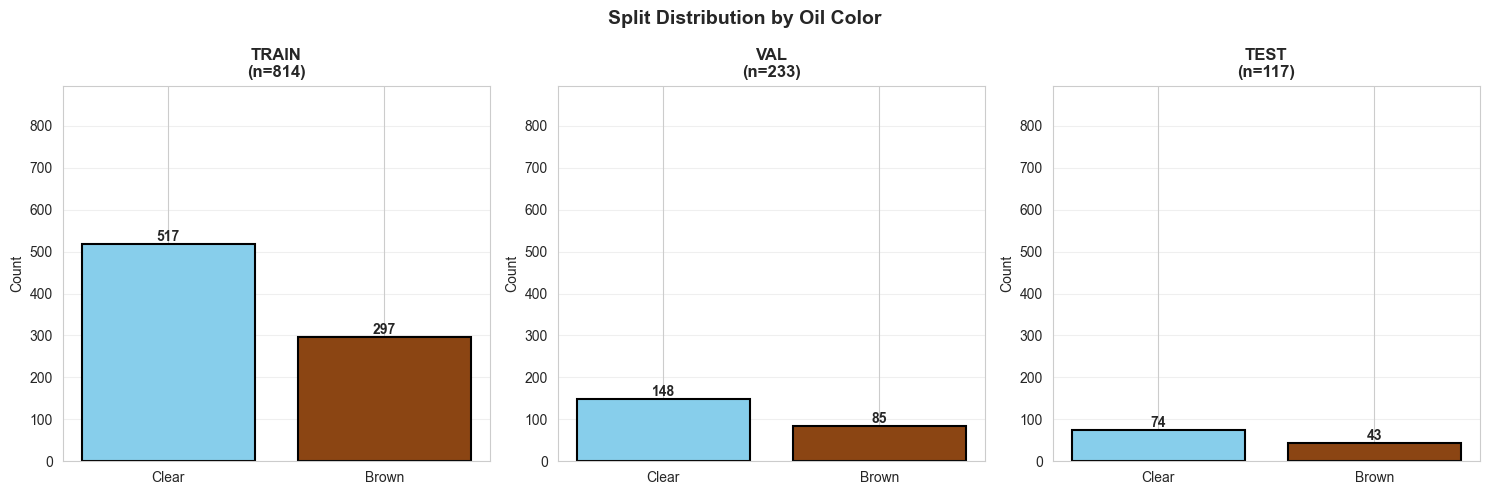


SUMMARY TABLE: SPLIT DISTRIBUTION (ANNOTATED + BACKGROUND)
Split  Annotated  Background  Total  Clear Clear %  Brown Brown %
TRAIN        814         280   1094    517   63.5%    297   36.5%
  VAL        233          80    313    148   63.5%     85   36.5%
 TEST        117          40    157     74   63.2%     43   36.8%

BACKGROUND IMAGE STATISTICS:
TRAIN:
  Annotated images (with objects): 814
  Background images (no objects): 280
  Total images: 1094
  Background ratio: 25.6%
VAL:
  Annotated images (with objects): 233
  Background images (no objects): 80
  Total images: 313
  Background ratio: 25.6%
TEST:
  Annotated images (with objects): 117
  Background images (no objects): 40
  Total images: 157
  Background ratio: 25.5%


In [26]:
# Create visualizations for split distribution
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
fig.suptitle('Split Distribution by Oil Color', fontsize=14, fontweight='bold')

splits = ['train', 'val', 'test']
colors_list = ['Clear', 'Brown']
color_palette = {'Clear': '#87CEEB', 'Brown': '#8B4513'}

for idx, split_name in enumerate(splits):
    data = split_distribution[split_name]
    counts = [data['Clear'], data['Brown']]
    
    # Create bar chart
    bars = axes[idx].bar(colors_list, counts, color=[color_palette[c] for c in colors_list], edgecolor='black', linewidth=1.5)
    
    # Add value labels on bars
    for bar in bars:
        height = bar.get_height()
        axes[idx].text(bar.get_x() + bar.get_width()/2., height,
                      f'{int(height)}',
                      ha='center', va='bottom', fontweight='bold')
    
    total = sum(counts)
    axes[idx].set_title(f'{split_name.upper()}\n(n={total})', fontweight='bold')
    axes[idx].set_ylabel('Count')
    axes[idx].set_ylim(0, max([split_distribution[s]['Clear'] + split_distribution[s]['Brown'] for s in splits]) * 1.1)
    axes[idx].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

# Create a summary table with background statistics
print("\n" + "="*60)
print("SUMMARY TABLE: SPLIT DISTRIBUTION (ANNOTATED + BACKGROUND)")
print("="*60)

summary_data = []
split_stats = {
    'train': {'annotated': train_count, 'background': train_bg_count},
    'val': {'annotated': val_count, 'background': val_bg_count},
    'test': {'annotated': test_count, 'background': test_bg_count}
}

for split_name in ['train', 'val', 'test']:
    total = split_distribution[split_name]['Clear'] + split_distribution[split_name]['Brown']
    clear_pct = (split_distribution[split_name]['Clear'] / total * 100) if total > 0 else 0
    brown_pct = (split_distribution[split_name]['Brown'] / total * 100) if total > 0 else 0
    
    annotated = split_stats[split_name]['annotated']
    background = split_stats[split_name]['background']
    total_with_bg = annotated + background
    
    summary_data.append({
        'Split': split_name.upper(),
        'Annotated': annotated,
        'Background': background,
        'Total': total_with_bg,
        'Clear': split_distribution[split_name]['Clear'],
        'Clear %': f"{clear_pct:.1f}%",
        'Brown': split_distribution[split_name]['Brown'],
        'Brown %': f"{brown_pct:.1f}%"
    })

summary_df = pd.DataFrame(summary_data)
print(summary_df.to_string(index=False))
print("="*60)

# Print detailed background statistics
print("\nBACKGROUND IMAGE STATISTICS:")
print("="*60)
for split_name in ['train', 'val', 'test']:
    annotated = split_stats[split_name]['annotated']
    background = split_stats[split_name]['background']
    total_with_bg = annotated + background
    bg_pct = (background / total_with_bg * 100) if total_with_bg > 0 else 0
    
    print(f"{split_name.upper()}:")
    print(f"  Annotated images (with objects): {annotated}")
    print(f"  Background images (no objects): {background}")
    print(f"  Total images: {total_with_bg}")
    print(f"  Background ratio: {bg_pct:.1f}%")
print("="*60)

## Combining Annotations from filtered-split and oil-stick-detection

In [ ]:
import xml.etree.ElementTree as ET
from pathlib import Path
import json
from typing import Dict, List, Tuple, Optional
import numpy as np

# Paths
FILTERED_SPLIT_DIR = Path('../data/filtered-split')
OIL_STICK_DETECTION_DIR = Path('../data/oil-stick-detection')
BACKGROUND_DIR = Path('../data/_background')
CVAT_ANNOT_XML = FILTERED_SPLIT_DIR / 'annotations_filtered.xml'
OUTPUT_DIR = Path('../data/combined_annotations')

# Create output directory
OUTPUT_DIR.mkdir(exist_ok=True)

print(f"Filtered split path: {FILTERED_SPLIT_DIR}")
print(f"Oil stick detection path: {OIL_STICK_DETECTION_DIR}")
print(f"Background path: {BACKGROUND_DIR}")
print(f"Output directory: {OUTPUT_DIR}")

In [ ]:
class CVATAnnotationParser:
    """Parse CVAT XML format annotations with color attributes"""
    
    def __init__(self, xml_path: Path):
        self.tree = ET.parse(xml_path)
        self.root = self.tree.getroot()
        self.image_map = {}  # filename -> image_data
        self._parse_annotations()
    
    def _parse_annotations(self):
        """Parse all images and their annotations from CVAT XML"""
        for image_elem in self.root.findall('.//image'):
            name = image_elem.get('name')
            width = int(image_elem.get('width'))
            height = int(image_elem.get('height'))
            image_id = image_elem.get('id')
            
            annotations = []
            
            # Process polygons and polylines
            for poly_elem in image_elem.findall('polygon'):
                label = poly_elem.get('label')
                points_str = poly_elem.get('points')
                points = self._parse_points(points_str)
                
                # Get color attribute if it exists
                color_attr = None
                for attr_elem in poly_elem.findall('attribute'):
                    if attr_elem.get('name') == 'color':
                        color_attr = attr_elem.text
                
                annotations.append({
                    'type': 'polygon',
                    'label': label,
                    'points': points,
                    'color': color_attr
                })
            
            for polyline_elem in image_elem.findall('polyline'):
                label = polyline_elem.get('label')
                points_str = polyline_elem.get('points')
                points = self._parse_points(points_str)
                
                annotations.append({
                    'type': 'polyline',
                    'label': label,
                    'points': points,
                    'color': None
                })
            
            self.image_map[name] = {
                'id': image_id,
                'width': width,
                'height': height,
                'annotations': annotations
            }
    
    def _parse_points(self, points_str: str) -> List[Tuple[float, float]]:
        """Parse points string 'x1,y1;x2,y2;...' to list of tuples"""
        points = []
        for point_pair in points_str.split(';'):
            if point_pair.strip():
                x, y = point_pair.split(',')
                points.append((float(x), float(y)))
        return points
    
    def get_image_annotations(self, filename: str) -> Optional[Dict]:
        """Get annotations for a specific image"""
        return self.image_map.get(filename)
    
    def get_all_images(self) -> List[str]:
        """Get all image filenames"""
        return list(self.image_map.keys())


print("CVATAnnotationParser class created")